Note: This script uses XGBoost, Matplotlib, and Seaborn.
Data loaded successfully.
Starting improved preprocessing...
Removed outliers. New train shape: (1458, 80)
Combined data shape: (2917, 79)
Creating new features...
Applied log transformation to 23 skewed features.
Preprocessing complete. Final data shape: X=(1458, 311), X_test=(1459, 311)

Generating feature correlation heatmap...


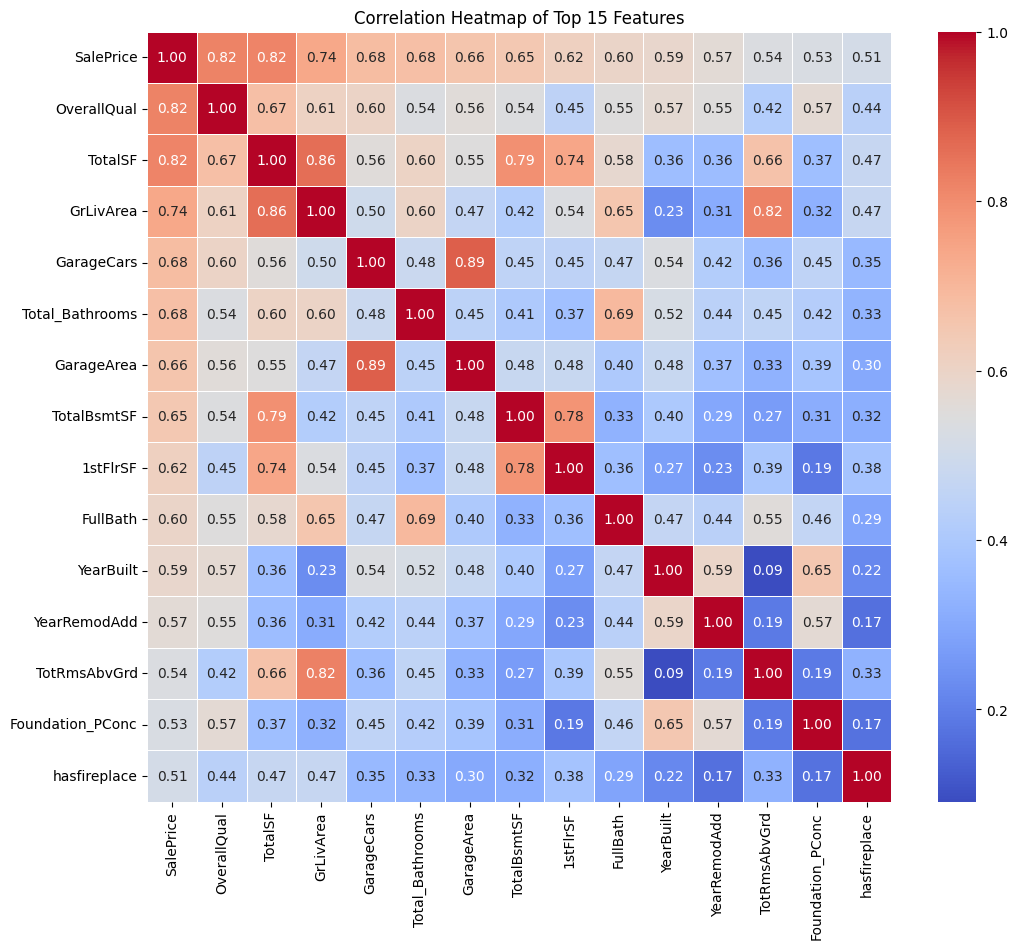

Starting model training with K-Fold cross-validation...
--- Fold 1/10 ---
Fold 1 Blended RMSE: 0.11460
--- Fold 2/10 ---
Fold 2 Blended RMSE: 0.13224
--- Fold 3/10 ---
Fold 3 Blended RMSE: 0.11531
--- Fold 4/10 ---
Fold 4 Blended RMSE: 0.10315
--- Fold 5/10 ---
Fold 5 Blended RMSE: 0.13743
--- Fold 6/10 ---
Fold 6 Blended RMSE: 0.10563
--- Fold 7/10 ---
Fold 7 Blended RMSE: 0.13167
--- Fold 8/10 ---
Fold 8 Blended RMSE: 0.11318
--- Fold 9/10 ---
Fold 9 Blended RMSE: 0.11873
--- Fold 10/10 ---
Fold 10 Blended RMSE: 0.09354

--- Model Evaluation ---
Average Cross-Validation Blended RMSE: 0.11655
--------------------------
Model training and blending complete.

Note: Plotting learning curves for LightGBM only due to XGBoost environment conflict.


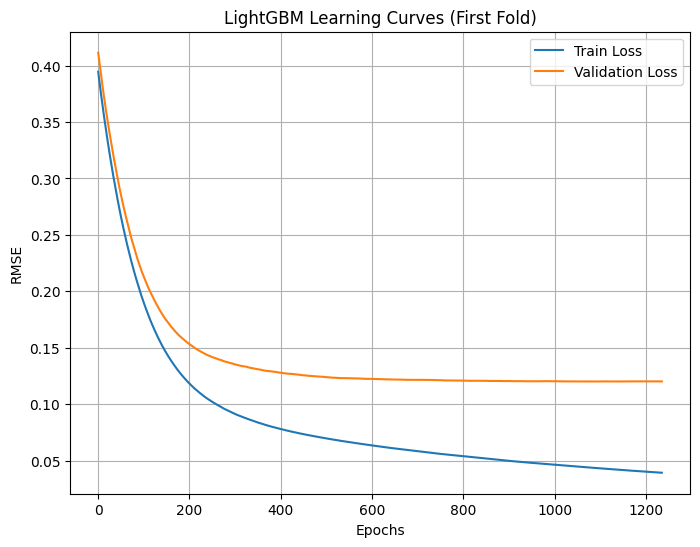


--- Visualizing Bias and Variance ---
The learning curves plot helps diagnose model performance:
🎯 **Good Fit:** Train and validation loss both decrease and converge at a low point.
🤔 **High Bias (Underfitting):** Both losses converge and plateau at a high value.
😲 **High Variance (Overfitting):** A large gap appears between a low training loss and a high validation loss.
---------------------------------------


Submission file 'submission.csv' created successfully.
     Id      SalePrice
0  1461  124866.873166
1  1462  163096.422563
2  1463  182714.028178
3  1464  192149.365181
4  1465  183614.094592


In [10]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import skew

# --- NEW VISUALIZATION IMPORTS ---
import matplotlib.pyplot as plt
import seaborn as sns

# Add a note for the user about required libraries
print("Note: This script uses XGBoost, Matplotlib, and Seaborn.")


# --- 1. Data Loading ---
def load_data():
    """Loads the training and testing datasets."""
    try:
        train_df = pd.read_csv('train.csv')
        test_df = pd.read_csv('test.csv')
        print("Data loaded successfully.")
        return train_df, test_df
    except FileNotFoundError:
        print("Error: train.csv or test.csv not found.")
        print("Please ensure the data files are in the same directory as the script.")
        return None, None

# --- 2. Preprocessing and Feature Engineering ---
def preprocess(train_df, test_df):
    """Handles missing values, outliers, feature engineering, and data transformation."""
    print("Starting improved preprocessing...")
    test_ids = test_df['Id']
    train_df = train_df.drop('Id', axis=1)
    test_df = test_df.drop('Id', axis=1)

    train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)
    print(f"Removed outliers. New train shape: {train_df.shape}")

    train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
    y = train_df['SalePrice']

    all_data = pd.concat((train_df.drop('SalePrice', axis=1), test_df))
    print(f"Combined data shape: {all_data.shape}")

    for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
                'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'):
        all_data[col] = all_data[col].fillna('None')

    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
                'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
        all_data[col] = all_data[col].fillna(0)

    for col in ('MSZoning', 'Utilities', 'Functional', 'Exterior1st', 'Exterior2nd',
                'KitchenQual', 'SaleType', 'Electrical'):
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

    all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
        lambda x: x.fillna(x.median()))

    print("Creating new features...")
    all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
    all_data['Total_Bathrooms'] = (all_data['FullBath'] + 0.5 * all_data['HalfBath'] +
                                   all_data['BsmtFullBath'] + 0.5 * all_data['BsmtHalfBath'])
    all_data['Total_Porch_SF'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                                  all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                                  all_data['WoodDeckSF'])
    all_data['YearBuilt_Age'] = all_data['YrSold'] - all_data['YearBuilt']
    all_data['YearRemod_Age'] = all_data['YrSold'] - all_data['YearRemodAdd']
    all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

    numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
    skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
    skewed_feats = skewed_feats[skewed_feats > 0.75].index
    all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
    print(f"Applied log transformation to {len(skewed_feats)} skewed features.")

    all_data = pd.get_dummies(all_data)

    X = all_data[:len(y)]
    X_test = all_data[len(y):]

    print(f"Preprocessing complete. Final data shape: X={X.shape}, X_test={X_test.shape}")
    return X, y, X_test, test_ids

# --- VISUALIZATION FUNCTIONS (MODIFIED) ---
def plot_learning_curves(lgb_evals):
    """Plots the training and validation loss (RMSE) for the LightGBM model."""
    plt.figure(figsize=(8, 6))
    
    # LightGBM Plot
    lgb_train_loss = lgb_evals['training']['rmse']
    lgb_val_loss = lgb_evals['valid_1']['rmse']
    plt.plot(lgb_train_loss, label='Train Loss')
    plt.plot(lgb_val_loss, label='Validation Loss')
    plt.title('LightGBM Learning Curves (First Fold)')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_bias_variance():
    """Prints an explanation of how to interpret learning curves."""
    print("\n--- Visualizing Bias and Variance ---")
    print("The learning curves plot helps diagnose model performance:")
    print("🎯 **Good Fit:** Train and validation loss both decrease and converge at a low point.")
    print("🤔 **High Bias (Underfitting):** Both losses converge and plateau at a high value.")
    print("😲 **High Variance (Overfitting):** A large gap appears between a low training loss and a high validation loss.")
    print("---------------------------------------\n")

def plot_feature_correlation(X, y):
    """Visualizes the correlation matrix for the top features related to SalePrice."""
    print("\nGenerating feature correlation heatmap...")
    train_data = pd.concat([X, y], axis=1)
    correlations = train_data.corr()
    top_features = correlations.nlargest(15, 'SalePrice')['SalePrice'].index
    top_corr_matrix = train_data[top_features].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(top_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
    plt.title('Correlation Heatmap of Top 15 Features')
    plt.show()

# --- 3. Model Training (MODIFIED) ---
def train_and_predict(X, y, X_test):
    """Trains LightGBM and XGBoost models and blends their predictions."""
    print("Starting model training with K-Fold cross-validation...")

    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    lgb_predictions = np.zeros(X_test.shape[0])
    xgb_predictions = np.zeros(X_test.shape[0])
    oof_rmse_scores = [] 

    # To store results for plotting
    first_fold_lgb_evals = {}
    
    for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
        print(f"--- Fold {fold+1}/10 ---")
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        lgb_eval_set = [(X_train, y_train), (X_val, y_val)]
        
        # --- a) LightGBM Model ---
        lgb_model = lgb.LGBMRegressor(objective='regression', metric='rmse', n_estimators=2000,
            learning_rate=0.01, feature_fraction=0.8, bagging_fraction=0.8,
            bagging_freq=1, lambda_l1=0.1, lambda_l2=0.1, num_leaves=31,
            verbose=-1, n_jobs=-1, seed=42)
        
        lgb_model.fit(X_train, y_train, eval_set=lgb_eval_set, eval_metric='rmse', 
                      callbacks=[lgb.early_stopping(100, verbose=False),
                                 lgb.record_evaluation(first_fold_lgb_evals if fold == 0 else {})])
        lgb_predictions += lgb_model.predict(X_test) / kf.n_splits

        # --- b) XGBoost Model ---
        xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', n_estimators=2000,
            learning_rate=0.01, max_depth=4, subsample=0.8,
            colsample_bytree=0.8, random_state=42, n_jobs=-1)
        
        # MODIFICATION: Removed early stopping for XGBoost to avoid the environment error.
        # This matches the script that you confirmed was working.
        xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        xgb_predictions += xgb_model.predict(X_test) / kf.n_splits
        
        # --- c) Evaluate fold performance ---
        val_preds_lgb = lgb_model.predict(X_val)
        val_preds_xgb = xgb_model.predict(X_val)
        blended_val_preds = 0.7 * val_preds_lgb + 0.3 * val_preds_xgb
        fold_rmse = np.sqrt(mean_squared_error(y_val, blended_val_preds))
        oof_rmse_scores.append(fold_rmse)
        print(f"Fold {fold+1} Blended RMSE: {fold_rmse:.5f}")

    mean_rmse = np.mean(oof_rmse_scores)
    print("\n--- Model Evaluation ---")
    print(f"Average Cross-Validation Blended RMSE: {mean_rmse:.5f}")
    print("--------------------------")

    blended_predictions = 0.7 * lgb_predictions + 0.3 * xgb_predictions
    print("Model training and blending complete.")
    
    # Call the visualization functions
    print("\nNote: Plotting learning curves for LightGBM only due to XGBoost environment conflict.")
    plot_learning_curves(first_fold_lgb_evals)
    visualize_bias_variance()
    
    return blended_predictions

# --- 4. Submission File Creation ---
def create_submission(test_ids, predictions):
    """Creates the submission file in the required format."""
    final_predictions = np.expm1(predictions)
    submission = pd.DataFrame({"Id": test_ids, "SalePrice": final_predictions})
    submission.to_csv('submission.csv', index=False)
    print("\nSubmission file 'submission.csv' created successfully.")
    print(submission.head())


# --- Main Execution ---
if __name__ == '__main__':
    train_df, test_df = load_data()
    if train_df is not None and test_df is not None:
        X, y, X_test, test_ids = preprocess(train_df, test_df)
        
        plot_feature_correlation(X, y)
        
        predictions = train_and_predict(X, y, X_test)
        create_submission(test_ids, predictions)